### Import Necessary Module and Set Path 

In [1]:
import sqlite3 as lite
import os
from IPython.display import Image
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()

In [2]:
import analysis as an

## ISSUES


## Run Cyclus Input file

In [3]:
! rm month.sqlite
! cyclus input.xml -o month.sqlite --warn-limit 0 

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

In [4]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('month.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

In [5]:
# plotting function
import matplotlib.pyplot as plt
def stacked_bar(dictionary, timestep, xlabel, ylabel,
                title, outputname, init_year, width):
    prev =np.zeros(1)
    top_index = True
    plot_list = []
    for key in dictionary:
        label = str(key)
        if sum(dictionary[key]) == 0:
            print(label + ' has no values')
        elif top_index is True:
            plot = plt.bar(x=init_year + timestep,
                           height=dictionary[key],
                           width=width,
                           edgecolor='none',
                           label=label)
            prev = dictionary[key]
            top_index = False
            plot_list.append(plot)
        else:
            plot = plt.bar(x=init_year + timestep,
                           height=dictionary[key],
                           width=width,
                           edgecolor='none',
                           bottom=prev,
                           label=label)
            prev =np.add(prev, dictionary[key])
            plot_list.append(plot)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    axes = plt.gca()
    axes.autoscale(tight=True)
    plt.grid(True)
    plt.legend()
    plt.savefig(outputname + '.png', format='png',
                bbox_inches='tight')
    plt.close()
    

def twosum(timeseries_list):
    """Aggregates timeseries list of length 2x to x
       by summing up the two adjacent values"""
    result = [0]
    list_indx = 0
    total = 0
    timeseries_list = timeseries_list[1:]
    while True:
        total += timeseries_list[list_indx]
        list_indx += 1
        if list_indx == len(timeseries_list) - 1:
            break
        if list_indx%12 == 0:
            result.append(total)
            total = 0
    return result

half_length = int((len(timestep)+1) / 12)
new_timestep = timestep[:half_length]


def read_from_data(data_path):
    """Reads from excel answer from Bo Feng from file"""
    file = open(data_path, 'r')
    timeseries = [0]
    for row in file:
        value = float(row.replace('\n', ''))
        timeseries.append(value)
    return timeseries[:-3]

def push_back_one(timeseries):
    out = np.array(timeseries)
    out = np.append(out, timeseries[-1])
    return out[1:]

def pull_in_one(timeseries):
    out = np.array(timeseries)
    out = np.append(timeseries[0], out)
    return out[:-1]

### The output file should be named 
         
          month.sqlite

In [6]:
# get number of reactors and capacity timeseries
power_dict = an.get_power_dict(cur)
stacked_bar(power_dict, timestep, 'Year', 'Deployed Capacity [GWe]',
            'Deployed reactor capacityies at the end of each year.',
            'power_plot', init_year, 1)
! mv power_plot.png ./results/power_plot.png

fac has no values


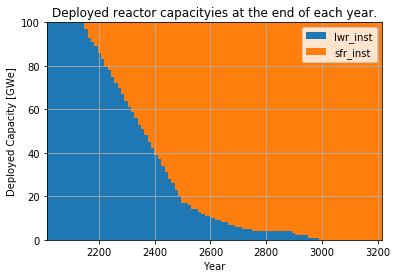

In [7]:
Image('./results/power_plot.png')

In [8]:
# get deployment scheme
dep_dict = {}

# lwr decommission
lwr_dec = cur.execute('SELECT exittime FROM agentexit '
                      'INNER JOIN agententry ON '
                      'agentexit.agentid = agententry.agentid '
                      'WHERE prototype = "lwr"').fetchall()
dec_array = np.zeros(duration)
exittime_list = []
for row in lwr_dec:
    exittime_list.append(row['exittime'])
for i in range(1,duration):
    dec_array[i-1] = exittime_list.count(i)

dep_dict['LWRs retired'] = dec_array

# sfr deployment
sfr_dep = cur.execute('SELECT entertime FROM agententry '
                      'where prototype = "sfr"').fetchall()
dep_array = np.zeros(duration)
entertime_list = []
for row in sfr_dep:
    entertime_list.append(row['entertime'])
for i in range(1, duration):
    dep_array[i-1] = entertime_list.count(i)

dep_dict['SFRs started up'] = dep_array


# read from data
data_lwr_decom = read_from_data('./bo/lwr_decom')
data_lwr_decom = push_back_one(data_lwr_decom)
data_sfr_dep = read_from_data('./bo/sfr_deploy')
data_sfr_dep = push_back_one(data_sfr_dep)

plt.bar(init_year + new_timestep, twosum(dep_dict['LWRs retired']),
        label='LWRs retired', width=0.8)
plt.plot(init_year + new_timestep, data_lwr_decom, label='LWRs retired [EXCEL]')

plt.bar(init_year + new_timestep, twosum(dep_dict['SFRs started up']),
        label='SFRs started up', alpha=0.4, width=0.8)
plt.plot(init_year + new_timestep, data_sfr_dep, label='SFRs started up [EXCEL]')

plt.ylabel('Reactors')
plt.xlabel('Year')
plt.title('LWRs retired and SFRs started up each year')
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.legend()
plt.yticks(np.arange(0,15, 2))
plt.savefig('./results/dep.png', format='png',
            bbox_inches='tight')
plt.close()


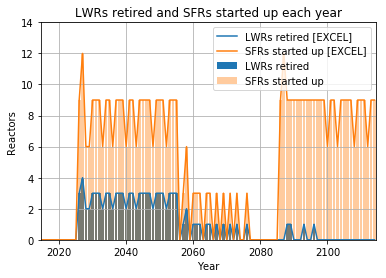

In [9]:
Image("./results/dep.png")

[ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.       25.999896 25.999896 25.999896
 25.999896 25.999896 25.999896 25.999896 25.999896 25.999896 25.999896
 25.999896 25.999896 25.999896 25.999896 25.999896 25.999896 25.999896
 25.999896 25.999896 25.999896 25.999896 25.999896 25.999896 25.999896
 25.999896 25.999896 25.999896 25.999896 22.609912 11.90618  11.12969
  9.31788   9.83554   9.05905   8.28256   4.40011   5.43543   6.21192
  3.62362   4.65894   4.40011   4.14128   2.84713   3.88245   3.62362
  2.32947   3.36479   2.07064   3.10596   1.81181   2.84713   1.55298
  2.5883    1.29415   1.29415   2.32947   1.03532   1.03532   1.03532
  1.03532   1.03532   1.03532   1.03532   1.03532   1.03532   1.03532
  1.03532   2.07064   1.81181   0.51766   0.51766   0.51766   1.55298
  0.25883   0.25883   1.29415   0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.      ]


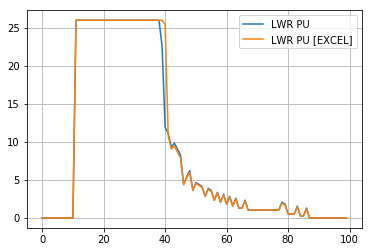

In [10]:
# sep lwr production


lwr_sep_agentid = an.get_prototype_id(cur, 'uox_reprocessing')
lwr_pu_prod = an.facility_commodity_flux(cur, lwr_sep_agentid, ['uox_pu'], True, False)

pu_output = cur.execute('SELECT time, value FROM separationevents '
                           'WHERE Type = "uox_pu" AND Agentid = ' + lwr_sep_agentid[0]).fetchall()
reprocessing_throughput = cur.execute('SELECT time, value FROM separationevents '
                                      'WHERE Type = "UNF" AND Agentid = ' + lwr_sep_agentid[0]).fetchall()


uox_pu = np.array(twosum(an.get_timeseries(pu_output, duration, True)))
print(uox_pu)
reprocessing_throughput = np.array(twosum(an.get_timeseries(reprocessing_throughput, duration, True))) * 0.013
data_lwr_pu = read_from_data('./bo/lwr_sep_tru')

plt.plot(new_timestep, uox_pu, label='LWR PU')
#plt.plot(new_timestep, reprocessing_throughput, linestyle=':', label="REP THROUGHPUT * PU FRAC")
plt.plot(new_timestep, data_lwr_pu, label = 'LWR PU [EXCEL]')
plt.grid()
plt.legend()
plt.show()

## Cycamore::Reactor only depletes half of its core when decommissioned. In this analysis, an edit to the source code is made so that all the core is depleted, like the other codes in the benchmark

No handles with labels found to put in legend.


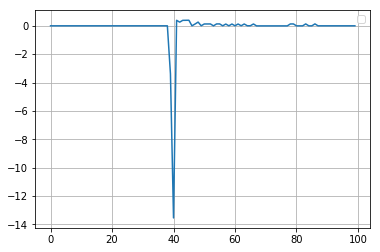

In [11]:
# find difference in previous plot
diff = uox_pu - np.array(data_lwr_pu)
plt.plot(new_timestep, diff)
plt.grid()
plt.legend()
plt.show()

## This result is because the CYCAMORE::REACTOR, when decommissioned mid-cycle, only depletes half of its core. The remaining half is un-depleted (enriched UOX). Thus half of the discharged fuel from decommissioned reactors do not contain plutonium.

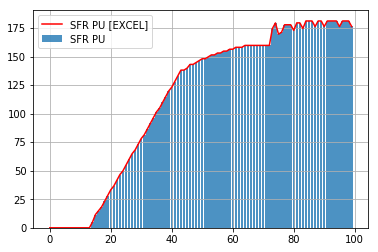

In [12]:
# sep sfr pu production
sfr_sep_agentid = an.get_prototype_id(cur, 'sfr_reprocessing')
sfr_pu_prod = an.facility_commodity_flux(cur, sfr_sep_agentid, ['sfr_pu'], True, False)

sfr_pu = np.array(twosum(sfr_pu_prod['sfr_pu']))
data_sfr_pu = read_from_data('./bo/sfr_sep_tru')

plt.bar(new_timestep, sfr_pu, label='SFR PU', alpha=0.8)
plt.plot(new_timestep, data_sfr_pu, label='SFR PU [EXCEL]', color='r' )
plt.grid()
plt.legend()
plt.show()

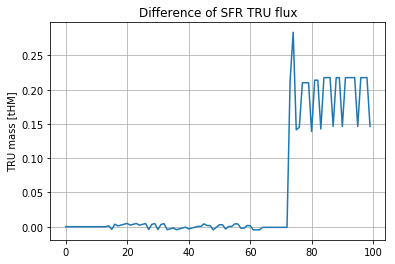

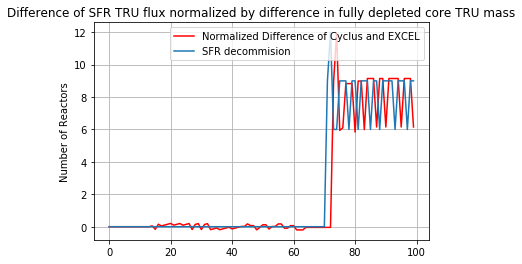

In [68]:
diff = np.array(sfr_pu) - np.array(data_sfr_pu)
norm_diff = diff / 0.0238
plt.plot(new_timestep, diff)
plt.title('Difference of SFR TRU flux')
plt.ylabel('TRU mass [tHM]')
plt.grid()
plt.show()
plt.close()



sfr_dec = cur.execute('SELECT exittime FROM agentexit '
                      'INNER JOIN agententry ON '
                      'agentexit.agentid = agententry.agentid '
                      'WHERE prototype = "sfr"').fetchall()
dec_array = np.zeros(duration)
exittime_list = []
for row in sfr_dec:
    exittime_list.append(row['exittime'])
for i in range(1,duration):
    dec_array[i-1] = exittime_list.count(i)
dep_dict['LWRs retired'] = dec_array

plt.plot(new_timestep, norm_diff, label='Normalized Difference of Cyclus and EXCEL', color='r')
plt.plot(new_timestep, twosum(dep_dict['LWRs retired']), label='SFR decommision')
plt.legend()
plt.title('Difference of SFR TRU flux normalized by difference in fully depleted core TRU mass')
plt.ylabel('Number of Reactors')
plt.grid()
plt.show()
plt.close()



## The Difference in mass TRU flux laggs the SFR decommission by one timestep because the decomssion stage is the very last step of Cyclus time execution, and the next material exchange occurs the next timestep.

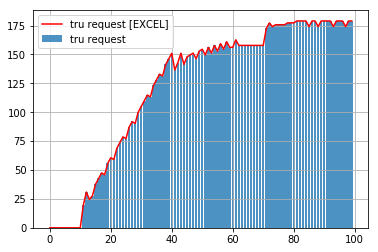

In [14]:

mixer_agentid = an.get_prototype_id(cur, 'sfr_mixer_sfr')
tru_request = an.facility_commodity_flux(cur, mixer_agentid, ['sfr_fuel'], True, False)
tru_request = np.array(tru_request['sfr_fuel']) * 0.1387
tru_request = twosum(tru_request)
tru_request.append(tru_request[-1])
tru_request = tru_request[1:]


# data tru request
data_tru_request = read_from_data('./bo/tru_request')

plt.bar(new_timestep, tru_request, label='tru request', alpha=0.8)
plt.plot(new_timestep, data_tru_request, label='tru request [EXCEL]', color='r')

plt.grid()
plt.legend()
plt.show()
plt.close()


12.634649999999851


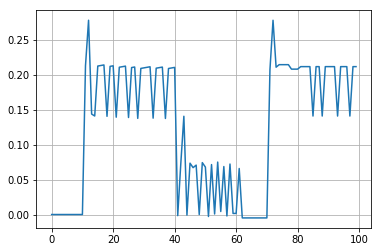

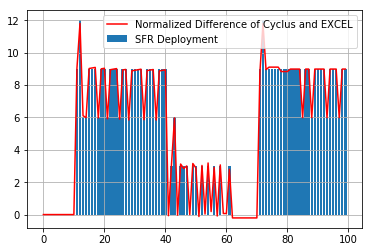

In [62]:
diff = np.array(tru_request) - np.array(data_tru_request)
norm_diff = diff / 0.023579
print(sum(diff))
plt.plot(new_timestep, diff)
plt.grid()
plt.show()
plt.close()

plt.plot(new_timestep, norm_diff, label= 'Normalized Difference of Cyclus and EXCEL', color='r')
plt.bar(new_timestep, twosum(dep_dict['SFRs started up']), label='SFR Deployment')
plt.title('Difference of TRU demand normalized by difference in startup core TRU mass')
plt.legend()
plt.grid()
plt.show()
plt.close()




## Notice that the normalized difference matches the SFR deployment, which means that the error is due to the difference in SFR core size.

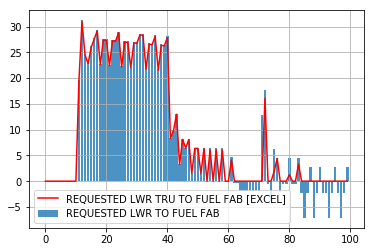

In [16]:
# requested LWR TRU to fuel fab
requested_lwr_tru = np.array(tru_request) - sfr_pu
data_lwr_tru = read_from_data('./bo/requested_lwr_tru')


plt.bar(new_timestep, requested_lwr_tru , label = 'REQUESTED LWR TO FUEL FAB', alpha=0.8)
plt.plot(new_timestep, data_lwr_tru , label = 'REQUESTED LWR TRU TO FUEL FAB [EXCEL]', color='r')
plt.grid()
plt.legend()
plt.show()
plt.close()

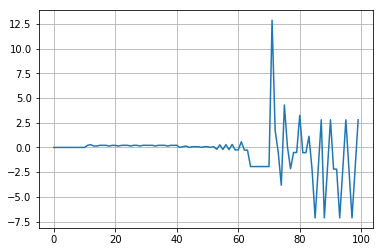

In [17]:
# find the difference of previous plot

diff = requested_lwr_tru - np.array(data_lwr_tru)
plt.plot(new_timestep, diff)
plt.grid()
plt.show()
plt.close()

## The difference is caused by the core mass
## the paper has 3.95 tHM batch with 3.96 batches = 15.63 tHM per core
## Cyclus, with its discrete batch has 3.95 tHM batch with 4 batches = 15.8 tH per core
## Thus Cyclus requires 0.17 tHM more fuel at startup. 
## that is 0.023579 tHM more TRU to start up
## and 0.0238 tHM more when the core discharge at decommission is reprocessed

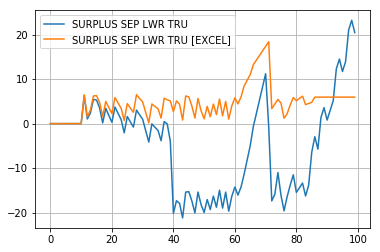

In [18]:
# surplus separated TRU
# is euqal to:
# Separated LWR TRU - requested LWR TRU to fuel fab

surplus_lwr_tru = np.zeros(len(new_timestep))
for indx, val in enumerate(surplus_lwr_tru):
    if indx == 1:
        continue
    surplus_lwr_tru[indx] = surplus_lwr_tru[indx-1] + uox_pu[indx] - requested_lwr_tru[indx]

data_surplus_lwr_tru = read_from_data('./bo/surplus_sep_lwr_tru')

#plt.plot(new_timestep, requested_lwr_tru, label='REQUESTED LWR PU')
#plt.plot(new_timestep, uox_pu, label='UOX PU')
plt.plot(new_timestep, surplus_lwr_tru, label='SURPLUS SEP LWR TRU')
plt.plot(new_timestep, data_surplus_lwr_tru, label='SURPLUS SEP LWR TRU [EXCEL]')

plt.grid()
plt.legend()
plt.show()
plt.close()

## This plot is produced by following the steps in the EXCEL sheet where the surplus separated LWR TRU is given by the cumulative value of (separated LWR TRU) - (requested LWR TRU to fuel fab). Since the requested LWR TRUs are more because the LWR core size is bigger, and the requested LWR TRU to fuel fab is 

In [19]:
# unsed TRU recovered from UNF

# separated pu timeseries
pu_influx = cur.execute('SELECT time, Value FROM separationevents '
                        'WHERE type = "uox_pu" OR type = "sfr_pu"').fetchall()
pu_inv_timeseries = twosum(an.get_timeseries(pu_influx, duration, True))

# pu usage
sfr_agentid = an.get_prototype_id(cur, 'sfr_mixer_sfr')
sfr_load = an.facility_commodity_flux(cur, sfr_agentid, ['sfr_fuel'], True, False)
pu_used = np.array(sfr_load['sfr_fuel']) * 0.1387

pu_used = twosum(pu_used)
pu_used = np.append(np.array(pu_used), pu_used[-1])
pu_used = pu_used[1:]

leftover = np.cumsum(pu_inv_timeseries - pu_used)



plt.plot(new_timestep, leftover, label='TRU LEFTOVER')
plt.xlabel('Year')
plt.ylabel('Unused TRU from UNF [tHM]')
plt.title('Inventory of unused TRU recovered from UNF')
axes = plt.gca()
plt.grid(True)
plt.savefig('./results/tru.png', format='png',
            bbox_inches='tight')
plt.close()

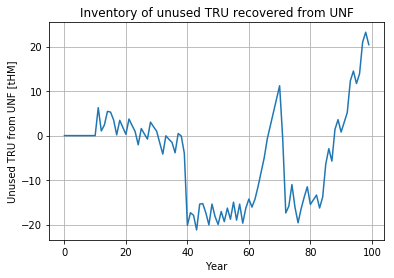

In [20]:
Image('./results/tru.png')

In [21]:
# Annual Fresh Fuel Loading Rates

# lwr fuel loading 
lwr_agentid = an.get_prototype_id(cur, 'lwr')
lwr_load = an.facility_commodity_flux(cur, lwr_agentid,
                                      ['uox'], False, False)
## have to make the first datapoint equal to the second datapoint (BC)
## the first datapoint lwr_load['uox'][1] 
## is the initial loading of all lwrs
lwr_load['uox'][1] = lwr_load['uox'][2]
lwr_load['uox'][0] = lwr_load['uox'][1]
# aggregate
new_lwr_load =  twosum(lwr_load['uox'])
new_lwr_load[1] = new_lwr_load[2]
# sfr fuel loading
sfr_agentid = an.get_prototype_id(cur, 'sfr')
sfr_load = an.facility_commodity_flux(cur, sfr_agentid,
                                      ['sfr_fuel'],
                                      False, False)
# aggregate
new_sfr_load = twosum(sfr_load['sfr_fuel'])

## Get from data
data_lwr_load = read_from_data('./bo/lwr_fuel_loaded')
data_sfr_load = read_from_data('./bo/sfr_fuel_loaded')


plt.plot(new_timestep + init_year , new_lwr_load,
         label='LWR Fresh Fuel')
plt.plot(new_timestep + init_year , data_lwr_load,
         label='LWR Fresh Fuel [EXCEL]', linestyle = ':')

plt.plot(new_timestep + init_year, new_sfr_load,
         label='SFR Fresh Fuel')
plt.plot(new_timestep + init_year, data_sfr_load,
         label='SFR Fresh Fuel [EXCEL]', linestyle = ':')

print(new_lwr_load)
print(data_lwr_load)
plt.xlabel('Year')
plt.ylabel('Fresh Fuel Loading [MTHM]')
plt.legend()
axes = plt.gca()
plt.grid(True)
plt.savefig('./results/fuel_load.png', format='png',
            bbox_inches='tight')
plt.close()

[0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1931.27, 1851.63, 1811.81, 1771.99, 1712.26, 1652.53, 1592.8, 1552.98, 1493.25, 1433.52, 1393.7, 1333.97, 1274.24, 1214.51, 1174.69, 1114.96, 1055.23, 1015.41, 955.6800000000001, 895.95, 836.22, 776.49, 736.67, 676.94, 617.21, 557.48, 517.66, 457.93, 398.2, 338.47, 338.47, 318.56, 278.74, 278.74, 258.83, 238.92000000000002, 219.01, 219.01, 199.1, 179.19, 179.19, 159.28, 159.28, 139.37, 139.37, 119.46000000000001, 119.46000000000001, 99.55, 99.55, 99.55, 79.64, 79.64, 79.64, 79.64, 79.64, 79.64, 79.64, 79.64, 79.64, 79.64, 79.64, 79.64, 59.730000000000004, 39.82, 39.82, 39.82, 39.82, 19.91, 19.91, 19.91, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1991.0, 1931.27, 1851.63, 1811.81, 1771.99, 1712.26, 1652.53, 1592.8, 1552.98, 1493.25, 1433.52, 1393.7, 1333.97, 1274.24, 

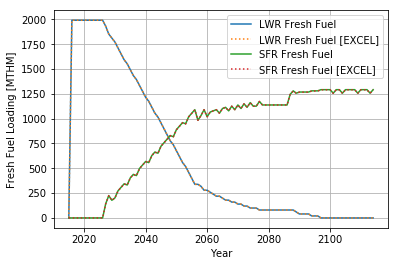

In [22]:
Image("./results/fuel_load.png")

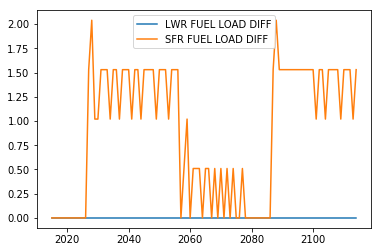

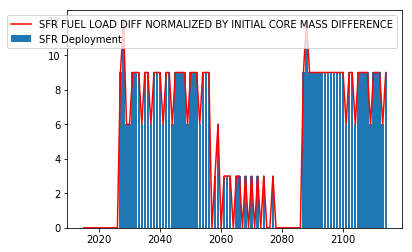

In [82]:
# difference in previous plot
diff_lwr_load = np.array(new_lwr_load) - np.array(data_lwr_load)
diff_sfr_load = np.array(new_sfr_load) - np.array(data_sfr_load)

plt.plot(new_timestep + init_year , diff_lwr_load,
         label='LWR FUEL LOAD DIFF' )
plt.plot(new_timestep + init_year, diff_sfr_load,
         label='SFR FUEL LOAD DIFF')
plt.legend()
plt.show()
plt.close()


norm_diff_sfr_load = diff_sfr_load / 0.17
plt.plot(new_timestep + init_year, norm_diff_sfr_load,
         label='SFR FUEL LOAD DIFF NORMALIZED BY INITIAL CORE MASS DIFFERENCE', color = 'r')

plt.bar(new_timestep + init_year, pull_in_one(twosum(dep_dict['SFRs started up'])), label='SFR Deployment')
plt.legend()
plt.show()
plt.close()

In [83]:
# Inventory of discharged and cooled UNF waiting for reprocessing

query_result = cur.execute('SELECT quantity FROM storageinventory '
                           'WHERE prototype = "uox_unf_storage" '
                           'AND status = "Cooling"').fetchall()
uox_storage_timeseries = [0]
for row in query_result:
    uox_storage_timeseries.append(row[0] / 1000.0)

sfr_query = cur.execute('SELECT quantity FROM storageinventory '
                        'WHERE prototype = "sfr_unf_storage" '
                        'AND status = "Cooling"').fetchall()
sfr_storage_timeseries = [0]
for row in sfr_query:
    sfr_storage_timeseries.append(row[0] / 1000.0)

# average of two timesteps
new_uox_storage = np.array(twosum(uox_storage_timeseries[:-1])) / 12
new_sfr_storage = np.array(twosum(sfr_storage_timeseries[:-1])) / 12

new_uox_storage = push_back_one(new_uox_storage)
print(new_uox_storage)

## get from data
data_uox_storage = read_from_data('./bo/lwr_cool')
data_sfr_storage = read_from_data('./bo/sfr_cool')


print(data_uox_storage)
plt.plot(new_timestep + init_year , new_uox_storage,
             label='LWR UNF')
plt.plot(new_timestep + init_year , data_uox_storage,
             label='LWR UNF [EXCEL]')

plt.plot(new_timestep + init_year, new_sfr_storage,
         label='SFR UNF')
plt.plot(new_timestep + init_year, data_sfr_storage,
         label='SFR UNF [EXCEL]')

plt.xlabel('Year')
plt.ylabel('Used Fuel in Cooling Storage [t]')
plt.title('Inventory of discharged UNF in mandatory cooling storage')
plt.legend()
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.savefig('./results/fuel_discharge.png', format='png',
            bbox_inches='tight')
plt.close()

[   0.         1991.         3982.         5973.         7798.08333333
 7798.08333333 7798.08333333 7798.08333333 7798.08333333 7798.08333333
 7798.08333333 8037.00333333 8295.83333333 8315.74333333 8275.92333333
 8055.25416667 7776.51416667 7660.3725     7438.04416667 7224.01166667
 7009.97916667 6722.94333333 6600.165      6386.1325     6178.73666667
 5956.40833333 5742.37583333 5528.34333333 5241.3075     5118.52916667
 4904.49666667 4697.10083333 4554.4125     4240.83       4026.7975
 3812.765      3605.36916667 3383.04083333 3169.00833333 2954.97583333
 2747.58       2365.97166667 2032.47916667 1818.44666667 1484.95416667
 1498.2275     1413.61       1270.92166667 1204.555      1146.48416667
 1088.41333333  957.33916667  990.5225      852.81166667  821.2875
  774.83083333  743.30666667  696.85        665.32583333  618.86916667
  507.705       560.79833333  449.63416667  429.72416667  403.1775
  311.92333333  311.92333333  311.92333333  311.92333333  311.92333333
  311.92333333  31

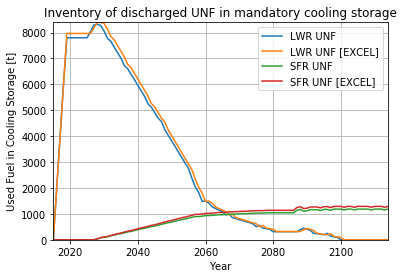

In [85]:
Image('./results/fuel_discharge.png')

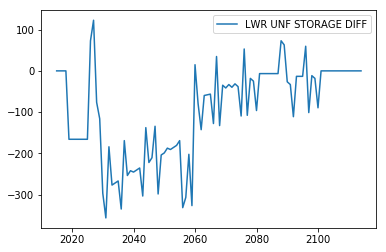

In [88]:
# difference in previous plot
diff_lwr_load = np.array(new_uox_storage) - np.array(data_uox_storage)
diff_sfr_load = np.array(new_sfr_storage) - np.array(data_sfr_storage)
plt.plot(new_timestep + init_year , diff_lwr_load,
         label='LWR UNF STORAGE DIFF' )
#plt.scatter(new_timestep + init_year, diff_sfr_load,
#         label='SFR UNF STORAGE DIFF')
plt.legend()
plt.show()
plt.close()


In [27]:
# Inventory of discharged and cooled UNF waiting for reprocessing
# Inventory of discharged and cooled UNF waiting for reprocessing


uox_storage_agentid = an.get_prototype_id(cur, 'uox_unf_storage')
uox_sent_out = an.facility_commodity_flux(cur, uox_storage_agentid,
                                          ['cooled_uox_unf'],
                                          True, True)
cooled = cur.execute('SELECT time, quantity FROM storageinventory '
                     'WHERE prototype = "uox_unf_storage" '
                     'AND status = "Cooled Inventory"').fetchall()
cooled = an.get_timeseries(cooled, duration, True)

sfr_storage_agentid = an.get_prototype_id(cur, 'sfr_unf_storage')
sfr_sent_out = an.facility_commodity_flux(cur, sfr_storage_agentid,
                                          ['cooled_sfr_unf'],
                                          True, True)

# subtract unf used
# pu outflux from reprocessing plants
uox_rep_agentid = an.get_prototype_id(cur, 'uox_reprocessing')
uox_pu_out = an.facility_commodity_flux(cur, uox_rep_agentid,
                                        ['uox_pu'], True, True)
sfr_rep_agentid = an.get_prototype_id(cur, 'sfr_reprocessing')
sfr_pu_out = an.facility_commodity_flux(cur, sfr_rep_agentid,
                                        ['sfr_pu'], True, True)


# just reprocessed amount
agentid = an.get_prototype_id(cur, 'uox_reprocessing')
uox_rep = cur.execute('SELECT time, Value FROM separationevents '
                      'WHERE type = "UNF" '
                      'AND Agentid = ' + agentid[0]).fetchall()


uox_rep_cum = an.get_timeseries_cum(uox_rep, duration, True)


diff = - np.array(uox_rep_cum) + np.array(uox_sent_out['cooled_uox_unf']) + np.array(cooled)

sfr_diff = - np.array(sfr_pu_out['sfr_pu']) / 0.1404 + np.array(sfr_sent_out['cooled_sfr_unf'])


## Get from data
data_cooled_uox = read_from_data('./bo/lwr_cooled')
data_cooled_sfr = read_from_data('./bo/sfr_cooled')

# plot the average 
plt.plot(new_timestep + init_year, np.array(twosum(diff)) / 12, label='LWR UNF')
plt.plot(new_timestep + init_year, data_cooled_uox, label='LWR UNF [EXCEL]')


plt.plot(new_timestep + init_year, np.array(twosum(sfr_diff)) / 12, label='SFR UNF')
plt.plot(new_timestep + init_year, data_cooled_sfr, label='SFR UNF [EXCEL]')

plt.xlabel('Year')
plt.ylabel('UNF waiting for Reprocessing [MTHM]')
plt.title('Inventory of discharge and cooled UNF waiting for reprocessing')
plt.legend()
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.savefig('./results/waiting.png', format='png',
            bbox_inches='tight')
plt.close()

In [28]:
# Cooled storage = To cooled storage - fuel reprocessed
to_cooled_storage = cur.execute('SELECT time,quantity FROM storageinventory '
                                'WHERE prototype = "uox_unf_storage" '
                                'AND status = "Now Cooled"').fetchall()
to_cooled_storage = an.get_timeseries(to_cooled_storage, duration, True)
to_cooled_storage = twosum(to_cooled_storage)

data_to_cooled_storage = read_from_data('./bo/lwr_to_cooled')

to_cooled_storage_sfr = cur.execute('SELECT time,quantity FROM storageinventory '
                                    'WHERE prototype = "sfr_unf_storage" '
                                    'AND status = "Now Cooled"').fetchall()
to_cooled_storage_sfr = an.get_timeseries(to_cooled_storage_sfr, duration, True)
to_cooled_storage_sfr =twosum(to_cooled_storage_sfr)


# Fuel Reprocessed
agentid = an.get_prototype_id(cur, 'uox_reprocessing')
uox_rep = cur.execute('SELECT time,value FROM separationevents '
                      'WHERE type = "UNF" '
                      'AND Agentid = ' + agentid[0]).fetchall()
uox_rep = an.get_timeseries(uox_rep, duration, True)
uox_rep = twosum(uox_rep)

data_uox_rep = read_from_data('./bo/lwr_rep')

agentid = an.get_prototype_id(cur, 'sfr_reprocessing')
sfr_rep = cur.execute('SELECT time,value FROM separationevents '
                      'WHERE type = "UNF" '
                      'AND Agentid = ' + agentid[0]).fetchall()
sfr_rep = an.get_timeseries(sfr_rep, duration, True)
sfr_rep = twosum(sfr_rep)



# the cumulative difference is the cooled inventory waiting for reprocessing
cooled_inv = np.zeros(len(data_uox_rep))
for indx, val in enumerate(cooled_inv):
    if indx == 0:
        continue
    cooled_inv[indx] = cooled_inv[indx-1] + to_cooled_storage[indx] - uox_rep[indx]

cooled_inv_sfr = np.zeros(len(data_uox_rep))
for indx, val in enumerate(cooled_inv_sfr):
    if indx == 0:
        continue
    cooled_inv_sfr[indx] = cooled_inv_sfr[indx-1] + to_cooled_storage_sfr[indx] - sfr_rep[indx]
    

data_cooled_inv = read_from_data('./bo/lwr_cooled')
data_cooled_inv_sfr = read_from_data('./bo/sfr_cooled')
    
plt.plot(new_timestep, cooled_inv, label='LWR UNF')
plt.plot(new_timestep, data_cooled_inv, label='LWR UNF [EXCEL]')
plt.plot(new_timestep, cooled_inv_sfr, label='SFR UNF')
plt.plot(new_timestep, data_cooled_inv_sfr, label='SFR UNF [EXCEL]')

plt.xlabel('Year')
plt.ylabel('UNF waiting for Reprocessing [MTHM]')
plt.title('Inventory of discharge and cooled UNF waiting for reprocessing')
plt.legend()
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.savefig('./results/waiting.png', format='png',
            bbox_inches='tight')
plt.close()

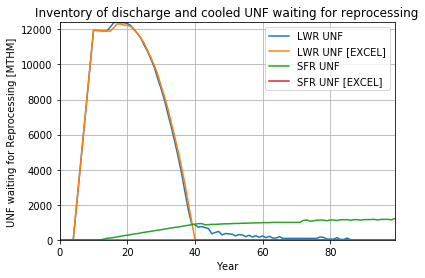

In [29]:
Image('./results/waiting.png')

In [30]:
# annual reprocessing throughput
uox_rep_agentid = an.get_prototype_id(cur, 'uox_reprocessing')
uox_rep = cur.execute('SELECT Time, Value from separationevents '
                      'WHERE Type = "UNF" AND Agentid = ' + uox_rep_agentid[0]).fetchall()
uox_rep = twosum(an.get_timeseries(uox_rep, duration, True))

sfr_rep_agentid = an.get_prototype_id(cur, 'sfr_reprocessing')
sfr_rep = cur.execute('SELECT Time, Value from separationevents '
                      'WHERE Type = "UNF" AND Agentid = ' + sfr_rep_agentid[0]).fetchall()
sfr_rep = twosum(an.get_timeseries(sfr_rep, duration, True))

# get from data
data_uox_rep = read_from_data('./bo/lwr_rep')
data_sfr_rep = read_from_data('./bo/sfr_rep')

plt.plot(new_timestep + init_year, uox_rep, label='LWR UNF')
plt.plot(new_timestep + init_year, data_uox_rep, label='LWR UNF [EXCEL]')

plt.plot(new_timestep + init_year, sfr_rep, label='SFR UNF')
plt.plot(new_timestep + init_year, data_sfr_rep, label='SFR UNF [EXCEL]')

plt.xlabel('Year')
plt.ylabel('Annual Reprocessing Rate [t/y]')
plt.title('Annual reprocessing throughputs')
plt.legend()
axes = plt.gca()
plt.grid(True)
plt.savefig('./results/rep.png', format='png',
            bbox_inches='tight')
plt.close()


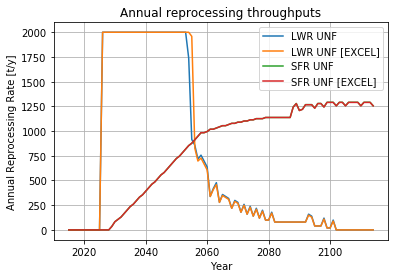

In [31]:
Image('./results/rep.png')

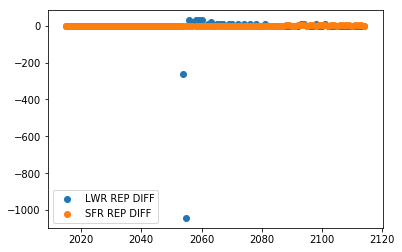

In [32]:
# difference in previous plot
diff_lwr_load = np.array(uox_rep) - np.array(data_uox_rep)
diff_sfr_load = np.array(sfr_rep) - np.array(data_sfr_rep)

plt.scatter(new_timestep + init_year , diff_lwr_load,
         label='LWR REP DIFF' )
plt.scatter(new_timestep + init_year, diff_sfr_load,
         label='SFR REP DIFF')
plt.legend()
plt.show()
plt.close()
